In [1]:
from pysheds.grid import Grid
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import meteomatics.api as api
import datetime as dt
import rioxarray

# import tiff file

In [ ]:
###Credentials:
username = 'python-community'
password = 'Umivipawe179'

In [ ]:
lat_N = 41.249
lon_W = -118.859
lat_S = 35.206
lon_E = -114.147
res = 0.1

In [ ]:
startdate_grid = dt.datetime.utcnow().replace(hour=0, minute=0, second=0, microsecond=0)

In [ ]:
elev = api.query_grid(
  startdate_grid, 'elevation:m', lat_N, lon_W,
  lat_S, lon_E, res, res, username, password
)

In [ ]:
elev[elev <= 0.0] = np.nan
da = elev.T.unstack().to_xarray()
nc = da.to_dataset(name='elevation')
nc

In [ ]:
nc.rio.set_spatial_dims( 'lon', 'lat', inplace=True)
nc.rio.set_crs("epsg:4326", inplace=True)
nc.rio.to_raster('elevation.tif') 
grid = Grid.from_raster('elevation.tif')
dem = grid.read_raster('elevation.tif')

In [2]:
path_dem = r'D:\mehdi\DailyData\nevada_basin8\nevada_8s_of_a_6.tif'
grid = Grid.from_raster(path_dem)
dem = grid.read_raster(path_dem)

d:\mehdi\.venv\lib\site-packages\pysheds\io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
d:\mehdi\.venv\lib\site-packages\pysheds\io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


# Elevation to flow direction

In [3]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(dem, dirmap=dirmap)
fdir

Raster([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Compute accumulation from flow direction

In [4]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)


# Delineate catchment from flow direction

In [5]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = -115.24, 35.30

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

# Extract the river network

In [6]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

# Compute flow distance from flow direction

In [7]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')



Text(0.5, 1.0, 'Flow Distance')

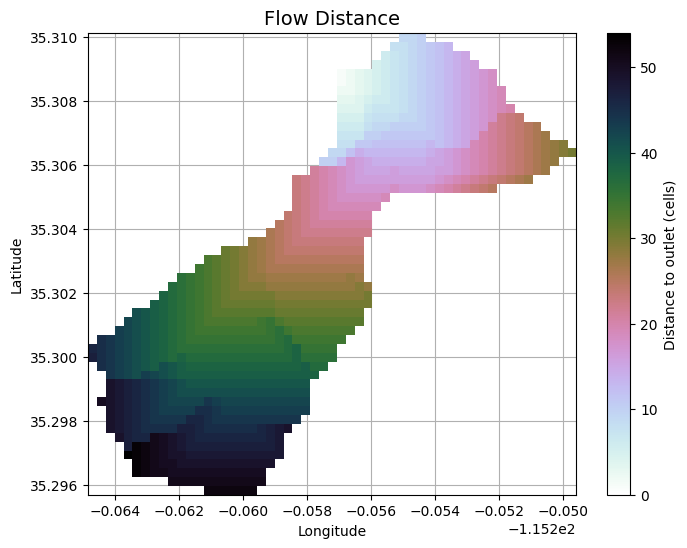

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)